In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [43]:
number_of_points = 50
in_channels1 = 1
out_channels1 = 16
kernel_size1 = (16, 2) 
out_channels2 = 32
kernel_size2 = (8, 2)
out_channels3 = 64
kernel_size3 = (4, 2)
kernel_size4 = (16,2)
padding = (0, 1)
dimInt = (number_of_points-kernel_size1[0]+1-kernel_size2[0]+1-kernel_size3[0]+1)
latent_dim = 400
hidden_dim = 100
batch_size = 32

In [44]:
def f_y_1(x0, x1):
    return torch.sin(5 * x0 + 3 * x1)

def f_y_2(x0, x1):
    return torch.cos(4 * x0 + 8 * x1)

In [45]:
class Encoder(nn.Module):
    def __init__(self, in_channels1, out_channels1, kernel_size1, out_channels2, kernel_size2, out_channels3, kernel_size3, dimInt, latent_dim):
        super(Encoder, self).__init__()
        
        self.C1 = nn.Conv2d(in_channels1, out_channels1, kernel_size=kernel_size1)
        self.relu = nn.ReLU()

        self.C2 = nn.Conv2d(out_channels1, out_channels2, kernel_size=kernel_size2)
        self.tanh = nn.Tanh()

        self.C3 = nn.Conv2d(out_channels2, out_channels3, kernel_size=kernel_size3)
        
        self.mu = nn.Linear(out_channels3 * dimInt, latent_dim)
        
        self.log_var = nn.Linear(out_channels3 * dimInt, latent_dim)
        
    def forward(self, x, cond):

        # print(x.shape, cond.shape)
        x_ = torch.cat([x, cond], dim=3)
        # print(x_.shape)

        x_ = self.relu(self.C1(x_))
        # print(x_.shape)

        x_ = self.tanh(self.C2(x_))
        # print(x_.shape)

        x_ = self.relu(self.C3(x_))
        # print(x_.shape)

        x_ = x_.view(x_.shape[0], -1)
        # print(x_.shape)
        
        z_mu = self.mu(x_)
        # print(z_mu.shape)
        
        z_log_var = self.log_var(x_)
        # print(z_log_var.shape)

        return z_mu, z_log_var

In [46]:
# class Sampling(nn.Module):
    
#     def __init__(self):
#         super(Sampling, self).__init__()
        
#     def forward(self, z_mu, z_log_var, temperature=1):
#         std = torch.exp(0.5 * z_log_var)
#         eps = torch.randn_like(std) * temperature
#         eps_factor = torch.rand_like(std)
#         eps = eps * eps_factor

#         return z_mu + eps * std

In [47]:
# class Sampling(nn.Module):
#     def __init__(self):
#         super(Sampling, self).__init__()

#     def forward(self, z_mu, z_log_var):
        
#         std = torch.exp(0.5 * z_log_var)
#         eps = torch.randn_like(std)
        
        
#         # print((z_mu + eps * std).shape)
        
#         return z_mu + eps * std

In [48]:
class AnnealedSampling(nn.Module):
    def __init__(self, initial_temperature=1.0, final_temperature=0.1, annealing_steps=10000):
        super(AnnealedSampling, self).__init__()
        self.initial_temperature = initial_temperature
        self.final_temperature = final_temperature
        self.annealing_steps = annealing_steps

    def forward(self, z_mu, z_log_var, global_step):
        progress = min(global_step / self.annealing_steps, 1.0)
        current_temperature = (1.0 - progress) * self.initial_temperature + progress * self.final_temperature

        std = torch.exp(0.5 * z_log_var)
        eps = torch.randn_like(std)

        # Introduce the annealed temperature parameter
        sampled_z = z_mu + current_temperature * eps * std

        return sampled_z

In [49]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, number_of_points, out_channels3, dimInt, out_channels2, kernel_size3, out_channels1, kernel_size2, in_channels1, kernel_size4, padding):
        super(Decoder, self).__init__()

        self.L1 = nn.Linear(latent_dim, hidden_dim)
        self.relu = nn.ReLU()

        self.L2 = nn.Linear(2*hidden_dim, out_channels3 * dimInt)
        self.tanh = nn.Tanh()

        self.CT1 = nn.ConvTranspose2d(out_channels3, out_channels2, kernel_size=kernel_size3)

        self.CT2 = nn.ConvTranspose2d(out_channels2, out_channels1, kernel_size=kernel_size2)

        self.CT3 = nn.ConvTranspose2d(out_channels1, in_channels1, kernel_size=kernel_size4,  padding=padding)


        
        self.number_of_points = number_of_points
    def forward(self, x, cond):
        
        # print(x.shape)
        # print(cond.shape)
        x = self.relu(self.L1(x))
        # print(x.shape)
        
        cond = torch.reshape(cond, (len(cond), self.number_of_points * 2))
        # print(cond.shape)
        x = torch.cat([x, cond], dim=1)
        # print(x.shape)

        x = self.tanh(self.L2(x))
        # print(x.shape)
        
        x = x.view(x.shape[0], out_channels3, -1, 1)
        # print(x.shape)

        x = self.relu(self.CT1(x))
        # print(x.shape)

        x = self.relu(self.CT2(x))
        # print(x.shape)
        
        x = self.relu(self.CT3(x))
        # print(x.shape)

        return x

In [50]:
class CVAE(nn.Module):
    def __init__(self, in_channels1, out_channels1, kernel_size1, out_channels2, kernel_size2, out_channels3, kernel_size3, dimInt, latent_dim, hidden_dim, number_of_points, kernel_size4, padding):
        super(CVAE, self).__init__()
        self.encoder = Encoder(in_channels1, out_channels1, kernel_size1, out_channels2, kernel_size2, out_channels3, kernel_size3, dimInt, latent_dim)
        self.annealedsampling = AnnealedSampling()
        self.decoder = Decoder(latent_dim, hidden_dim, number_of_points, out_channels3, dimInt, out_channels2, kernel_size3, out_channels1, kernel_size2, in_channels1, kernel_size4, padding)

    def forward(self, x, cond):
        z_mu, z_log_var = self.encoder(x, cond)

        z = self.annealedsampling(z_mu, z_log_var, 10)

        x_hat = self.decoder(z, cond)

        return z_mu, z_log_var, x_hat

In [51]:
Model = CVAE(in_channels1, out_channels1, kernel_size1, out_channels2, kernel_size2, out_channels3, kernel_size3, dimInt, latent_dim, hidden_dim, number_of_points, kernel_size4, padding)

In [52]:
train_dataset = torch.load('/kaggle/input/bh-data-1/train_dataset.pt')
X0_X1, Y1_Y2 = train_dataset.tensors
X0_X1.shape, Y1_Y2.shape

(torch.Size([100000, 1, 50, 2]), torch.Size([100000, 1, 50, 2]))

In [53]:
Train_Dataset = TensorDataset(X0_X1, Y1_Y2)
train_loader = DataLoader(Train_Dataset, batch_size=batch_size, shuffle=True)

In [54]:
def loss_function(x0_x1, x_hat, z_mu, z_log_var, y1_y2):
    
    num_samples = len(x0_x1)
    
    recon_loss_fn = torch.nn.L1Loss(reduction='mean')
    
    x_loss = recon_loss_fn(x0_x1, x_hat)
    x_loss = x_loss * 4
#     x_loss = x_loss / num_samples
    
    KLD = -0.5 * torch.sum(1 + z_log_var - z_mu.pow(2) - z_log_var.exp())

    x0 = x_hat[:,:,:,0]
    x1 = x_hat[:,:,:,1]
    y1 = f_y_1(x0, x1)
    y2 = f_y_2(x0, x1)
    y1 = y1.view(-1, 1, 50, 1)
    y2 = y2.view(-1, 1, 50, 1)
    y_hat = torch.cat([y1, y2], dim=3)
    y_loss = recon_loss_fn(y1_y2, y_hat)
#     y_loss = y_loss / num_samples
    
    
    return x_loss, KLD, y_loss, x_loss + KLD + y_loss

In [55]:
def generate_samples(num_samples, given_y):
    samples = torch.tensor([])
    samples = samples.to(device)
    givens = torch.tensor([])
    givens = givens.to(device)
    given_y = given_y.to(device)
    Model.eval()
    with torch.no_grad():
        for i, _ in enumerate(range(num_samples)):
            z_rand = torch.randn(1, 50, 2)
            z_rand = z_rand.to(device)
            z_mu, z_log_var = Model.encoder(torch.unsqueeze(z_rand, dim=0), given_y[i,:,:,:].unsqueeze(0))
            z = Model.annealedsampling(z_mu, z_log_var, 10)
            
            sample = Model.decoder(z, given_y[i,:,:,:])
            samples = torch.cat([samples, sample], dim=0)   
            
    givens = torch.cat([givens, given_y], dim=0) 

    return samples, givens

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [57]:
Model.to(device)

CVAE(
  (encoder): Encoder(
    (C1): Conv2d(1, 16, kernel_size=(16, 2), stride=(1, 1))
    (relu): ReLU()
    (C2): Conv2d(16, 32, kernel_size=(8, 2), stride=(1, 1))
    (tanh): Tanh()
    (C3): Conv2d(32, 64, kernel_size=(4, 2), stride=(1, 1))
    (mu): Linear(in_features=1600, out_features=400, bias=True)
    (log_var): Linear(in_features=1600, out_features=400, bias=True)
  )
  (annealedsampling): AnnealedSampling()
  (decoder): Decoder(
    (L1): Linear(in_features=400, out_features=100, bias=True)
    (relu): ReLU()
    (L2): Linear(in_features=200, out_features=1600, bias=True)
    (tanh): Tanh()
    (CT1): ConvTranspose2d(64, 32, kernel_size=(4, 2), stride=(1, 1))
    (CT2): ConvTranspose2d(32, 16, kernel_size=(8, 2), stride=(1, 1))
    (CT3): ConvTranspose2d(16, 1, kernel_size=(16, 2), stride=(1, 1), padding=(0, 1))
  )
)

In [58]:
def plot_samples(num_samples, x0_x1, y1_y2):
    x0_x1 = x0_x1.to("cpu")
    y1_y2 = y1_y2.to("cpu")
    for i in range(num_samples):
        
        x0 = x0_x1[i,0,:,0]
        x1 = x0_x1[i,0,:,1]
        y1 = y1_y2[i,0,:,0]
        y2 = y1_y2[i,0,:,1]
        y1_hat = f_y_1(x0, x1)
        y2_hat = f_y_2(x0, x1)
        plt.plot(x0.detach().numpy(), label="X0")
        plt.plot(x1.detach().numpy(), label="X1")
        plt.plot(y1.detach().numpy(), label="Y1")
        plt.plot(y2.detach().numpy(), label="Y2")
        plt.plot(y1_hat.detach().numpy(), label="Y1_hat")
        plt.plot(y2_hat.detach().numpy(), label="Y2_hat")
        plt.legend()
        plt.show()

In [59]:
for batch in train_loader:
    x1_x2, y1_y2 = batch 
    break

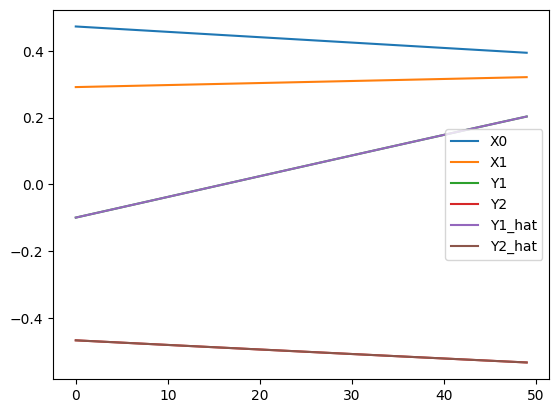

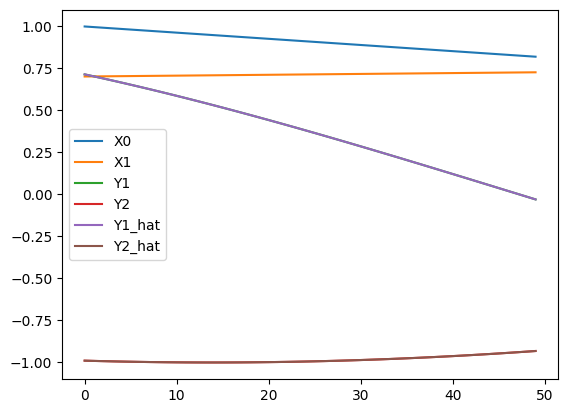

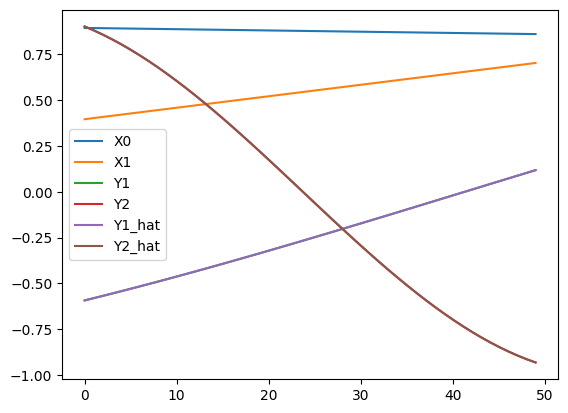

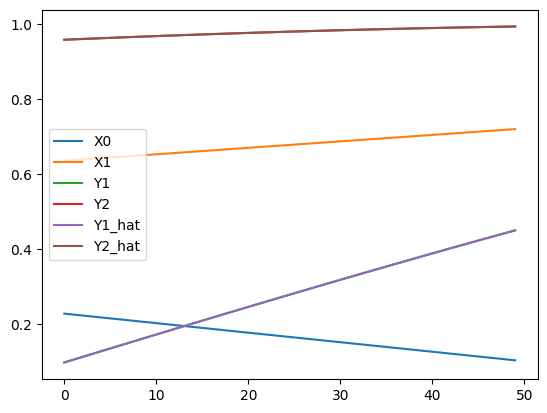

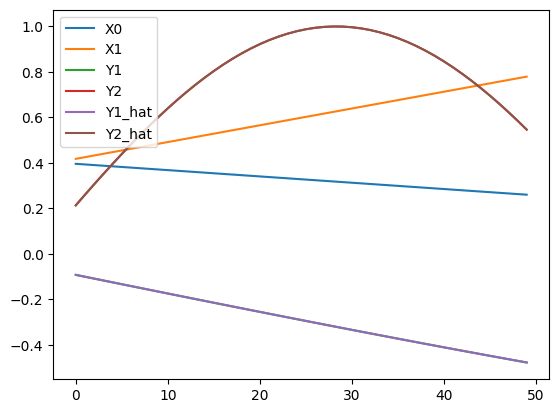

In [60]:
num_samples=5
plot_samples(num_samples, x1_x2, y1_y2)

In [61]:
num_samples = 5
for batch in train_loader:
    x1_x2, y1_y2 = batch 
    y_givens = y1_y2[:5,:,:,:]
    break

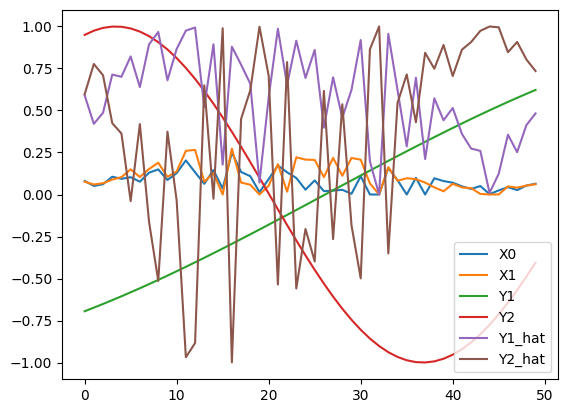

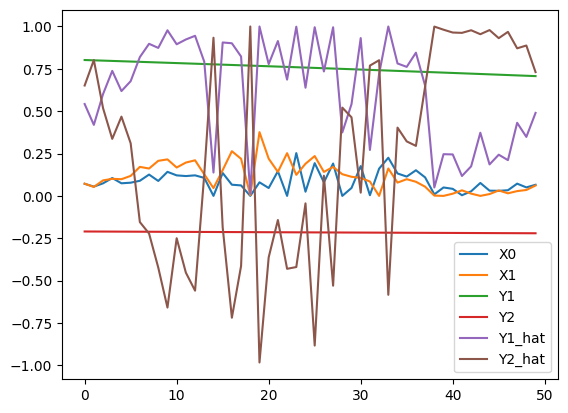

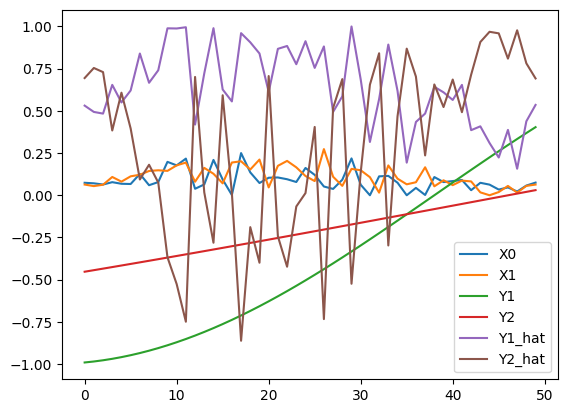

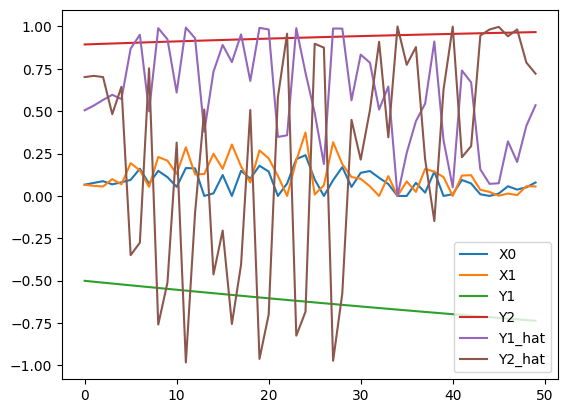

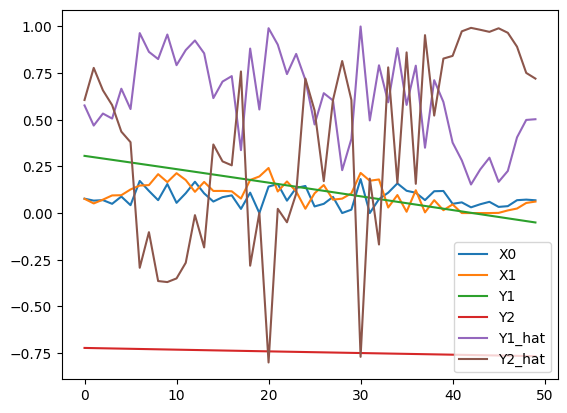

In [62]:
samples, givens = generate_samples(num_samples, y_givens)
plot_samples(num_samples, samples, givens)

In [63]:
Model.to(device)

CVAE(
  (encoder): Encoder(
    (C1): Conv2d(1, 16, kernel_size=(16, 2), stride=(1, 1))
    (relu): ReLU()
    (C2): Conv2d(16, 32, kernel_size=(8, 2), stride=(1, 1))
    (tanh): Tanh()
    (C3): Conv2d(32, 64, kernel_size=(4, 2), stride=(1, 1))
    (mu): Linear(in_features=1600, out_features=400, bias=True)
    (log_var): Linear(in_features=1600, out_features=400, bias=True)
  )
  (annealedsampling): AnnealedSampling()
  (decoder): Decoder(
    (L1): Linear(in_features=400, out_features=100, bias=True)
    (relu): ReLU()
    (L2): Linear(in_features=200, out_features=1600, bias=True)
    (tanh): Tanh()
    (CT1): ConvTranspose2d(64, 32, kernel_size=(4, 2), stride=(1, 1))
    (CT2): ConvTranspose2d(32, 16, kernel_size=(8, 2), stride=(1, 1))
    (CT3): ConvTranspose2d(16, 1, kernel_size=(16, 2), stride=(1, 1), padding=(0, 1))
  )
)

In [64]:
loss_ = []

In [65]:
optimizer = torch.optim.Adam(Model.parameters(), lr=0.001)

In [66]:
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=10, gamma=0.9)

In [67]:
epochs = 20

for epoch in range(epochs):
    running_x_loss = 0
    running_y_loss = 0
    running_KLD = 0
    running_loss = 0
    
    for batch in tqdm(train_loader):
        x0_x1, y1_y2 = batch
        x0_x1 = x0_x1.to(device)
        y1_y2 = y1_y2.to(device)
        
        Model.train()  
        z_mu, z_log_var, x_hat = Model(x0_x1, y1_y2)
        
        
        x_loss, KLD, y_loss, loss = loss_function(x0_x1, x_hat, z_mu, z_log_var, y1_y2)
        x_loss, KLD, y_loss, loss = x_loss.to(device), KLD.to(device), y_loss.to(device), loss.to(device)
        
        running_loss += loss.item()
        running_y_loss += y_loss.item()
        running_x_loss += x_loss.item()
        running_KLD += KLD.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    running_KLD = running_KLD / len(train_loader)
    running_loss = running_loss / len(train_loader)
    running_y_loss = running_y_loss / len(train_loader)
    running_x_loss = running_x_loss / len(train_loader)
    scheduler.step()
    
    loss_.append(running_loss)
    
    print(f'{epoch + 1}/{epochs} Loss: {running_loss} KLD: {running_KLD} y_loss: {running_y_loss} x_loss: {running_x_loss}')


  0%|          | 0/3125 [00:00<?, ?it/s]

1/20 Loss: 0.4813143426036835 KLD: 0.0075112500953674315 y_loss: 0.13781587799549103 x_loss: 0.3359872145676613


  0%|          | 0/3125 [00:00<?, ?it/s]

2/20 Loss: 0.3417787499809265 KLD: 9.482953071594238e-05 y_loss: 0.0868204771566391 x_loss: 0.2548634433269501


  0%|          | 0/3125 [00:00<?, ?it/s]

3/20 Loss: 0.2991612212181091 KLD: 8.619058609008789e-05 y_loss: 0.0796276144194603 x_loss: 0.21944741614580154


  0%|          | 0/3125 [00:00<?, ?it/s]

4/20 Loss: 0.26781151477336884 KLD: 9.1603422164917e-05 y_loss: 0.07107735864877701 x_loss: 0.19664255277872086


  0%|          | 0/3125 [00:00<?, ?it/s]

5/20 Loss: 0.24981542931318282 KLD: 9.36944580078125e-05 y_loss: 0.06469583901166916 x_loss: 0.18502589591979982


  0%|          | 0/3125 [00:00<?, ?it/s]

6/20 Loss: 0.23689757449388504 KLD: 9.18896484375e-05 y_loss: 0.05945427937030792 x_loss: 0.17735140555500983


  0%|          | 0/3125 [00:00<?, ?it/s]

7/20 Loss: 0.22863297978162767 KLD: 9.44671630859375e-05 y_loss: 0.05650234919309616 x_loss: 0.17203616352677345


  0%|          | 0/3125 [00:00<?, ?it/s]

8/20 Loss: 0.2217942090678215 KLD: 9.28021240234375e-05 y_loss: 0.05383259213268757 x_loss: 0.16786881499171258


  0%|          | 0/3125 [00:00<?, ?it/s]

9/20 Loss: 0.21522932566165925 KLD: 9.20001220703125e-05 y_loss: 0.05135727034509182 x_loss: 0.1637800552546978


  0%|          | 0/3125 [00:00<?, ?it/s]

10/20 Loss: 0.21039663367509842 KLD: 8.928131103515625e-05 y_loss: 0.0499091951829195 x_loss: 0.16039815722227097


  0%|          | 0/3125 [00:00<?, ?it/s]

11/20 Loss: 0.2024773669576645 KLD: 8.731475830078126e-05 y_loss: 0.04657463932156563 x_loss: 0.15581541296958923


  0%|          | 0/3125 [00:00<?, ?it/s]

12/20 Loss: 0.19827238662958147 KLD: 8.900421142578125e-05 y_loss: 0.0452205498790741 x_loss: 0.15296283258080481


  0%|          | 0/3125 [00:00<?, ?it/s]

13/20 Loss: 0.19538689048290253 KLD: 8.75830078125e-05 y_loss: 0.04420538224875927 x_loss: 0.15109392513632774


  0%|          | 0/3125 [00:00<?, ?it/s]

14/20 Loss: 0.19230674763441086 KLD: 8.651885986328125e-05 y_loss: 0.043058563964366914 x_loss: 0.14916166491508484


  0%|          | 0/3125 [00:00<?, ?it/s]

15/20 Loss: 0.1905655260682106 KLD: 8.701568603515625e-05 y_loss: 0.042808887684941295 x_loss: 0.14766962265372277


  0%|          | 0/3125 [00:00<?, ?it/s]

16/20 Loss: 0.18761137354135513 KLD: 8.473114013671876e-05 y_loss: 0.04189360662043095 x_loss: 0.14563303568840028


  0%|          | 0/3125 [00:00<?, ?it/s]

17/20 Loss: 0.18589868467092513 KLD: 8.5684814453125e-05 y_loss: 0.041743749675154686 x_loss: 0.14406925021886827


  0%|          | 0/3125 [00:00<?, ?it/s]

18/20 Loss: 0.1835959127688408 KLD: 8.41522216796875e-05 y_loss: 0.040727908526659015 x_loss: 0.14278385200977325


  0%|          | 0/3125 [00:00<?, ?it/s]

19/20 Loss: 0.1812076139640808 KLD: 8.29571533203125e-05 y_loss: 0.040091397107839585 x_loss: 0.1410332597923279


  0%|          | 0/3125 [00:00<?, ?it/s]

20/20 Loss: 0.18009030565977097 KLD: 8.06219482421875e-05 y_loss: 0.039562020704746244 x_loss: 0.14044766285181046


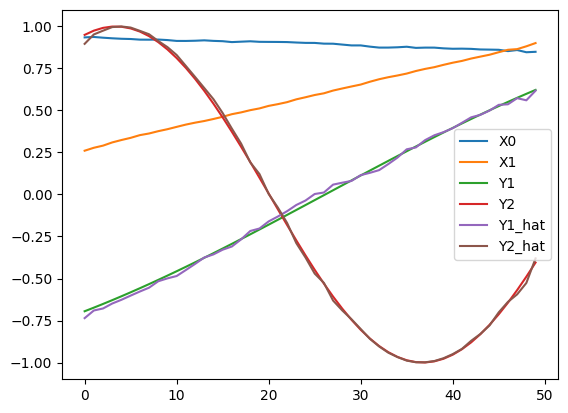

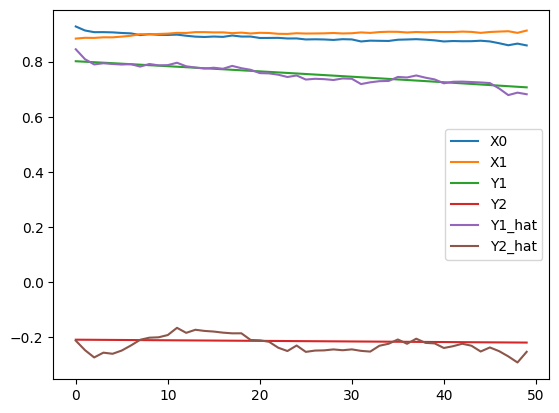

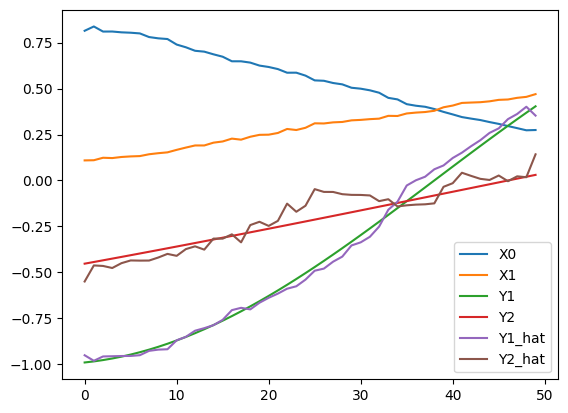

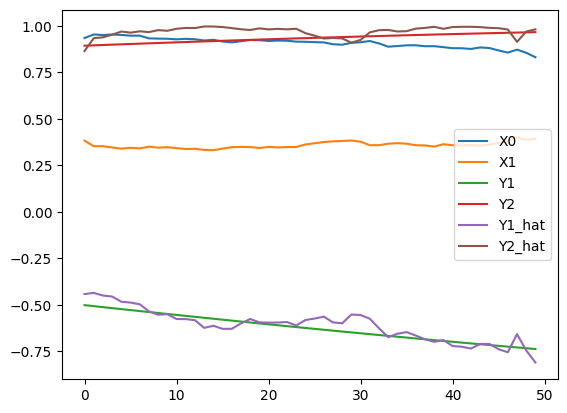

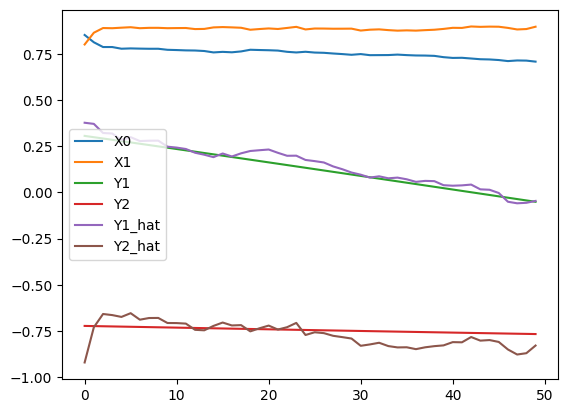

In [68]:
num_samples = 5
samples, givens = generate_samples(num_samples, y_givens)
plot_samples(num_samples, samples, givens)

In [69]:
score = torch.load("/kaggle/input/bh-data-1/scoring_dataset.pt")

In [70]:
b = score.tensors
print(len(b))
x_sc, y_sc = b
x_sc.shape, y_sc.shape

2


(torch.Size([50, 1, 50, 2]), torch.Size([50, 1, 50, 2]))

In [71]:
x_sc_1, y_sc_1 = x_sc[1,:,:,:],y_sc[1,:,:,:]
print(x_sc_1.shape,y_sc_1.shape)
x_sc_1 = torch.unsqueeze(x_sc_1, dim=0)
y_sc_1 = torch.unsqueeze(y_sc_1, dim=0)
print(x_sc_1.shape,y_sc_1.shape)

torch.Size([1, 50, 2]) torch.Size([1, 50, 2])
torch.Size([1, 1, 50, 2]) torch.Size([1, 1, 50, 2])


In [74]:
x0_x1 = torch.tensor([])
x0_x1 = x0_x1.to(device)
y1_y2 = torch.tensor([])
y1_y2 = y1_y2.to(device)
x_sc_1 = x_sc_1.to(device)
y_sc_1 = y_sc_1.to(device)
Model.eval()

for i in range(30):
    
    z_rand = torch.randn(1, 50, 2)
    z_rand = z_rand.to(device)
    z_mu, z_log_var = Model.encoder(torch.unsqueeze(z_rand, dim=0), y_sc_1)
    z = Model.annealedsampling(z_mu, z_log_var, 10)

#     z = torch.randn(1, latent_dim)
#     z = z.to(device)
#     z1 = torch.rand(1, latent_dim)
#     z1 = z1.to(device)
#     z = z * z1

            
    sample = Model.decoder(z, y_sc_1)
    
    x0_x1 = torch.cat([sample, x0_x1], dim=0)
    y1_y2 = torch.cat([y1_y2, y_sc_1])

In [76]:
Model.eval()
x0_x1 = torch.tensor([])
x0_x1 = x0_x1.to(device)
y1_y2 = torch.tensor([])
y1_y2 = y1_y2.to(device)

for i in range(50):
    x_sc_1, y_sc_1 = x_sc[i,:,:,:],y_sc[i,:,:,:]
    x_sc_1 = torch.unsqueeze(x_sc_1, dim=0)
    y_sc_1 = torch.unsqueeze(y_sc_1, dim=0)
    
    x_sc_1 = x_sc_1.to(device)
    y_sc_1 = y_sc_1.to(device)
    for j in range(30):
        z_rand = torch.randn(1, 50, 2)
        z_rand = z_rand.to(device)
        z_mu, z_log_var = Model.encoder(torch.unsqueeze(z_rand, dim=0), y_sc_1)
        z = Model.annealedsampling(z_mu, z_log_var, 10) 
        
        sample = Model.decoder(z, y_sc_1)
    
        x0_x1 = torch.cat([sample, x0_x1], dim=0)
        y1_y2 = torch.cat([y1_y2, y_sc_1], dim=0)

In [77]:
x0_x1.shape, y1_y2.shape

(torch.Size([1500, 1, 50, 2]), torch.Size([1500, 1, 50, 2]))

In [78]:
x0_x1 = x0_x1.to("cpu")
y1_y2 = y1_y2.to("cpu")

In [79]:
ouput = TensorDataset(x0_x1, y1_y2)

In [81]:
torch.save(ouput,"output_4.pt")

In [82]:
x0_x1[0,:,:,:]

tensor([[[0.5238, 0.3695],
         [0.4914, 0.3766],
         [0.4798, 0.3894],
         [0.4428, 0.4073],
         [0.4144, 0.4180],
         [0.4030, 0.4263],
         [0.3940, 0.4348],
         [0.3812, 0.4493],
         [0.3664, 0.4542],
         [0.3573, 0.4638],
         [0.3512, 0.4707],
         [0.3341, 0.4827],
         [0.3279, 0.4950],
         [0.3164, 0.5073],
         [0.2891, 0.5160],
         [0.2748, 0.5311],
         [0.2695, 0.5374],
         [0.2848, 0.5177],
         [0.2804, 0.5251],
         [0.2896, 0.5354],
         [0.2948, 0.5478],
         [0.2946, 0.5472],
         [0.2982, 0.5469],
         [0.3031, 0.5509],
         [0.3012, 0.5573],
         [0.3019, 0.5609],
         [0.2885, 0.5620],
         [0.2973, 0.5567],
         [0.2951, 0.5648],
         [0.2858, 0.5711],
         [0.2795, 0.5876],
         [0.2851, 0.5999],
         [0.2383, 0.6132],
         [0.1886, 0.6399],
         [0.1542, 0.6577],
         [0.1420, 0.6782],
         [0.1378, 0.6899],
 

In [83]:
x0_x1[1,:,:,:]

tensor([[[0.5226, 0.3719],
         [0.4904, 0.3788],
         [0.4789, 0.3913],
         [0.4425, 0.4089],
         [0.4140, 0.4195],
         [0.4029, 0.4277],
         [0.3939, 0.4360],
         [0.3815, 0.4502],
         [0.3673, 0.4549],
         [0.3583, 0.4643],
         [0.3523, 0.4710],
         [0.3351, 0.4829],
         [0.3288, 0.4952],
         [0.3173, 0.5078],
         [0.2897, 0.5169],
         [0.2755, 0.5315],
         [0.2695, 0.5371],
         [0.2846, 0.5181],
         [0.2788, 0.5249],
         [0.2857, 0.5349],
         [0.2920, 0.5464],
         [0.2925, 0.5459],
         [0.2963, 0.5471],
         [0.3003, 0.5512],
         [0.2974, 0.5580],
         [0.2979, 0.5612],
         [0.2839, 0.5626],
         [0.2928, 0.5574],
         [0.2906, 0.5652],
         [0.2810, 0.5723],
         [0.2761, 0.5893],
         [0.2839, 0.6024],
         [0.2411, 0.6148],
         [0.1909, 0.6428],
         [0.1592, 0.6641],
         [0.1479, 0.6848],
         [0.1421, 0.6971],
 